In [1]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import glob
import xarray as xr

import grid

%matplotlib inline

In [2]:
base = '/ocean/nsoontie/MEOPAR/LiveOcean/*/*UBC.nc'
files = glob.glob(base)
files.sort()

In [3]:
d = xr.open_dataset(files[0])
for f in files[1:]:
    with xr.open_dataset(f) as d1:
        d =xr.concat([d,d1],dim='ocean_time',data_vars='minimal')

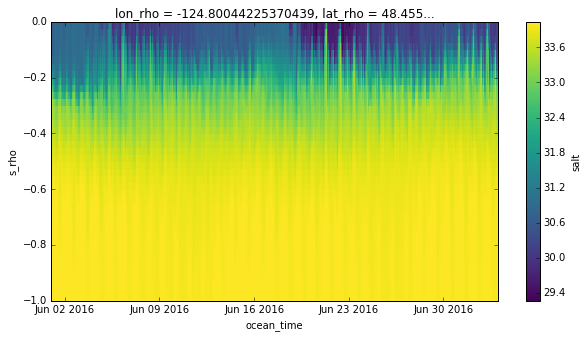

In [4]:
j=10
i=10
salt_ts = d.salt.sel(eta_rho=j,xi_rho=i)
fig, ax = plt.subplots(figsize=(10, 5))
salt_ts.plot(x='ocean_time', y='s_rho',ax=ax)

### Surface salintiy

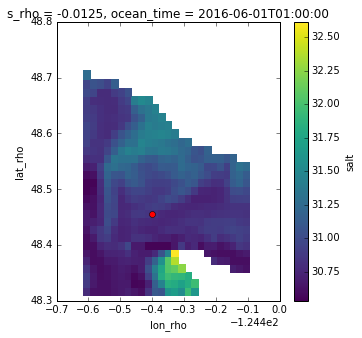

In [5]:
## Using sel in vertical instead of isel to select based on value
t = 0
s = 0
fig, ax = plt.subplots(figsize=(5, 5))
salt_surface = (
               d.salt.isel(ocean_time=t)
               .sel(s_rho=s,method='nearest')
)
salt_surface.plot(x='lon_rho', y='lat_rho',ax=ax)
ax.plot(d.lon_rho.values[j,i], d.lat_rho.values[j,i], 'ro')

### Bottom Salinity

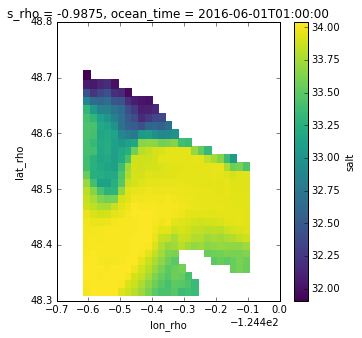

In [6]:
## Using isel in vertical instead of sel to select based on index
t = 0
s = 0
fig, ax = plt.subplots(figsize=(5, 5))
salt_bottom = (
               d.salt.isel(ocean_time=t,s_rho=s)
)
salt_bottom.plot(x='lon_rho', y='lat_rho',ax=ax)
ax.plot(i,j, 'ro')

Be careful! There is a dimension and a variable named s_rho:
* s_rho the dimension takes values 0 to 39, ie., indices BUT it starts at the bottom. So s_rho (dimension)=0 means bottom and s_rho(dimension) = 39 means surface
* s_rho the variable contains 40 values between -1 and 0. s_rho (variable) =0 means surface and s_rho (variable) = -1 means bottom

In [7]:
d.s_rho

<xarray.DataArray 's_rho' (s_rho: 40)>
array([-0.9875, -0.9625, -0.9375, -0.9125, -0.8875, -0.8625, -0.8375,
       -0.8125, -0.7875, -0.7625, -0.7375, -0.7125, -0.6875, -0.6625,
       -0.6375, -0.6125, -0.5875, -0.5625, -0.5375, -0.5125, -0.4875,
       -0.4625, -0.4375, -0.4125, -0.3875, -0.3625, -0.3375, -0.3125,
       -0.2875, -0.2625, -0.2375, -0.2125, -0.1875, -0.1625, -0.1375,
       -0.1125, -0.0875, -0.0625, -0.0375, -0.0125])
Coordinates:
  * s_rho    (s_rho) float64 -0.9875 -0.9625 -0.9375 -0.9125 -0.8875 -0.8625 ...
Attributes:
    standard_name: ocean_s_coordinate_g1
    valid_min: -1.0
    valid_max: 0.0
    field: s_rho, scalar
    long_name: S-coordinate at RHO-points
    positive: up
    formula_terms: s: s_rho C: Cs_r eta: zeta depth: h depth_c: hc

# Daily average of surface salinity

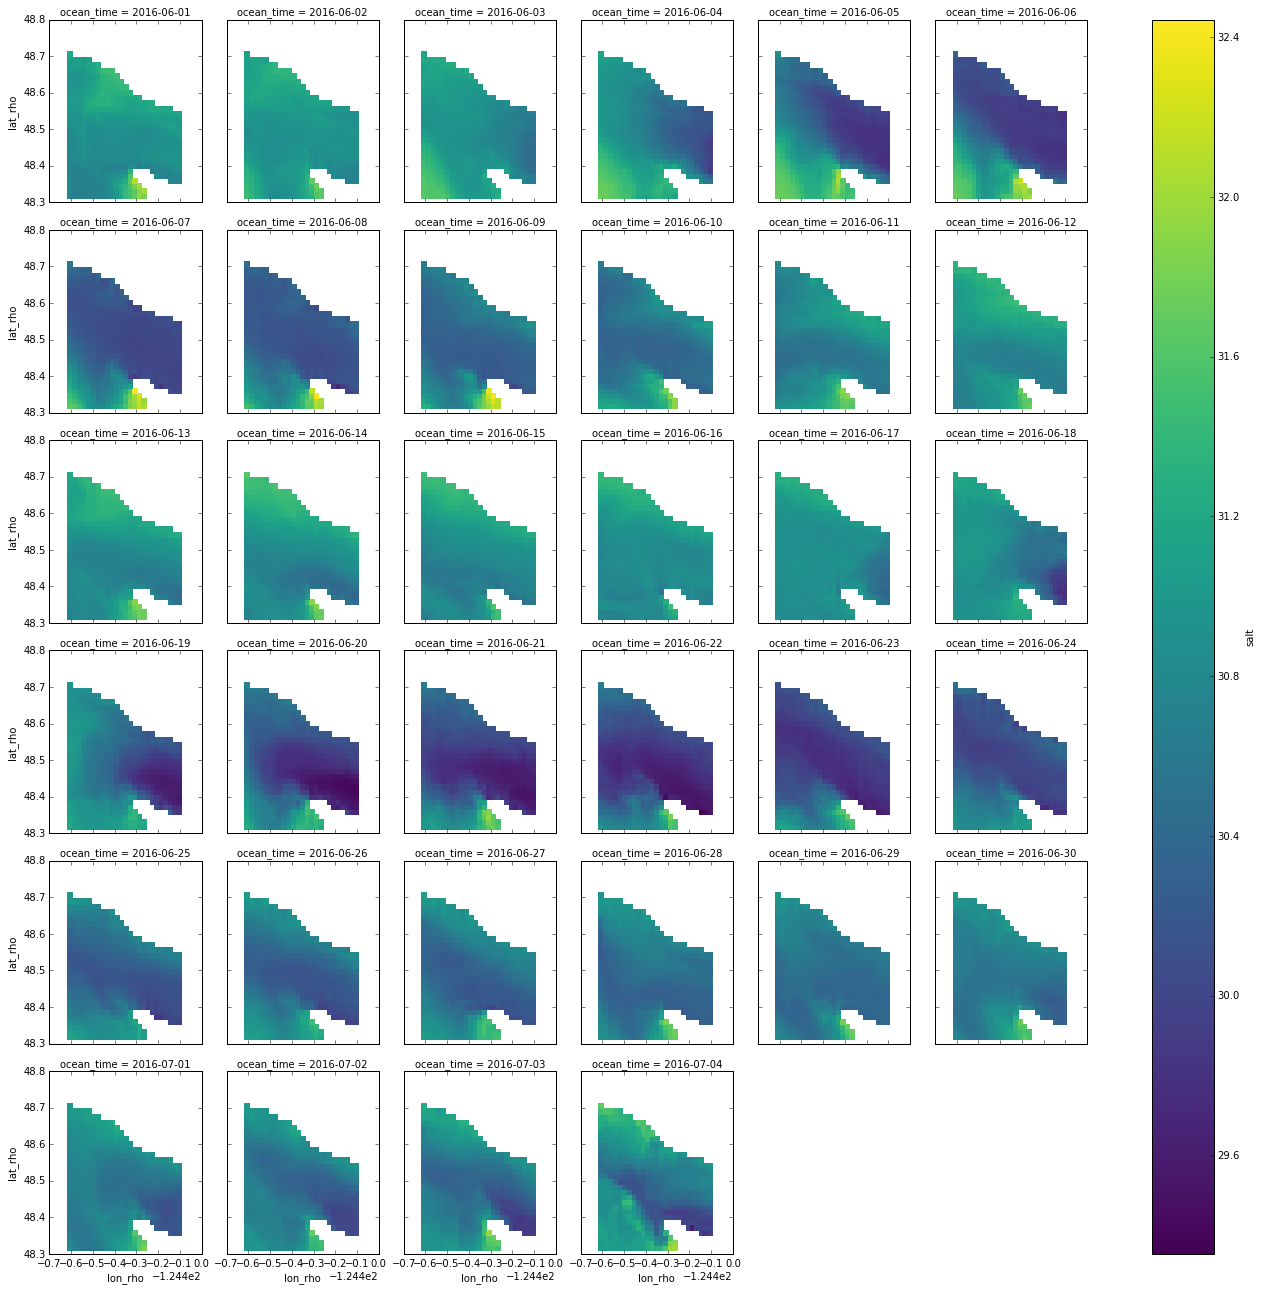

In [8]:
salt_surf_daily_avg = (
            d.salt.sel(s_rho=s,method='nearest')).resample('1D',dim='ocean_time')
g_simple = salt_surf_daily_avg.plot(x='lon_rho', y='lat_rho', col='ocean_time', col_wrap=6)

Because of the way I orgnanized the files, the first panel only has 23 hours of results and the last panel has one hour. It maybe be better to time_slice and then daily average.

# Adding depth to xarray
Can I add a depth coordinate (z_rho) to the xarray dataset?

In [9]:
import grid

In [10]:
#build depth
fname = '/ocean/nsoontie/MEOPAR/LiveOcean/20160601/ocean_his_0002_UBC.nc'
G, S, T = grid.get_basic_info(fname)
z_rho = np.zeros(d.salt.shape)
for t in np.arange(z_rho.shape[0]):
    zeta = d.zeta.values[t,:,:]
    z_rho[t,:,:,:] = grid.get_z(G['h'],zeta,S)

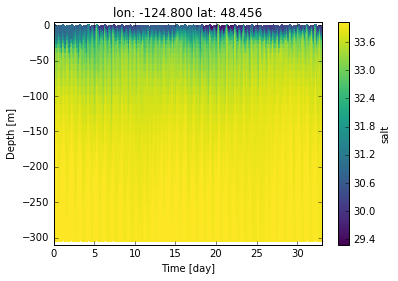

In [11]:
#quick peak
times, _ = np.meshgrid(np.arange(d.ocean_time.shape[0]),np.arange(z_rho.shape[1]))
plt.pcolormesh(times.T/24,z_rho[:,:,j,i],d.salt.values[:,:,j,i],cmap='viridis')
cbar=plt.colorbar()
plt.ylabel('Depth [m]')
plt.xlabel('Time [day]')
cbar.set_label('salt')
plt.axis([0,33,-310,5])
plt.title('lon: {:.3f} lat: {:.3f}'.format(d.lon_rho.values[j,i],d.lat_rho.values[j,i]))

In [12]:
#build a z_rho data array
zrho_DA = xr.DataArray(z_rho, dims = ['ocean_time','s_rho', 'eta_rho', 'xi_rho'],
                       coords = {'ocean_time': d.ocean_time.values[:],
                                 's_rho': d.s_rho.values[:],
                                 'eta_rho': d.eta_rho.values[:],
                                 'xi_rho': d.xi_rho.values[:]},
                       attrs = {'units': 'metres',
                                'positive': 'up',
                                'long_name': 'Depth at s-levels',
                                'field': 'z_rho ,scalar'})

In [13]:
#add z_rho to dataset
d = d.assign(z_rho = zrho_DA)
d = d.set_coords('z_rho') #make a coordinate
d.z_rho

<xarray.DataArray 'z_rho' (ocean_time: 792, s_rho: 40, eta_rho: 31, xi_rho: 26)>
array([[[[ -2.02345870e+02,  -2.35220118e+02,  -2.44251343e+02, ...,
                       nan,              nan,              nan],
         [ -2.07595682e+02,  -2.23752651e+02,  -1.99842358e+02, ...,
                       nan,              nan,              nan],
         [ -2.38688055e+02,  -2.41360546e+02,  -1.97477155e+02, ...,
                       nan,              nan,  -6.73887899e+01],
         ..., 
         [             nan,              nan,              nan, ...,
                       nan,              nan,              nan],
         [             nan,              nan,              nan, ...,
                       nan,              nan,              nan],
         [             nan,              nan,              nan, ...,
                       nan,              nan,              nan]],

        [[ -1.97913595e+02,  -2.30067128e+02,  -2.38900355e+02, ...,
                       nan,  

In [14]:
# Select a depth
salt_100m = d.sel(z_rho=100, method='nearest')
salt_100m.isel(ocean_time=0).plot(x='lon_rho',y='lat_rho')

ValueError: Coordinate objects must be 1-dimensional

Ok, so xarray doens't easily extract to a coordinate value if the coordinate arrays are not 1D. What about plotting agains z_rho?

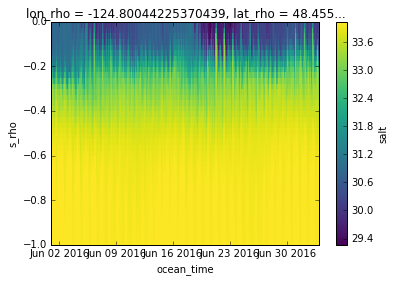

In [16]:
# check against s_rho first
salt_ts = d.salt.sel(eta_rho=10, xi_rho=10)
salt_ts.plot(x='ocean_time', y='s_rho')

TypeError: Incompatible X, Y inputs to pcolormesh; see help(pcolormesh)

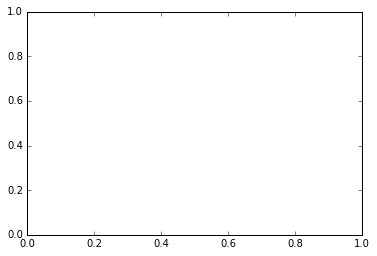

In [17]:
# try plotting with z_rho on y-axis
salt_ts.plot(x='ocean_time', y='z_rho')

I'm having troubles with this plot probably because ocean_time and z_rho are different shapes (z_rho has a time dimension too). Does the same thing happen if I try latitude on the y axis?

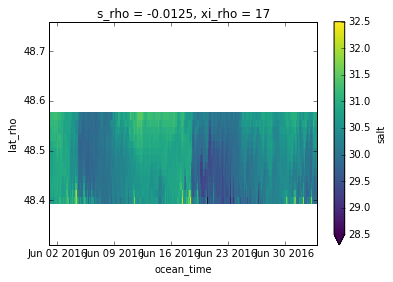

In [18]:
s=39
i=17
salt_surface_ts = d.salt.isel(s_rho=39, xi_rho=i)
salt_surface_ts.plot(x='ocean_time', y='lat_rho',vmin=28.5,vmax=32.5)

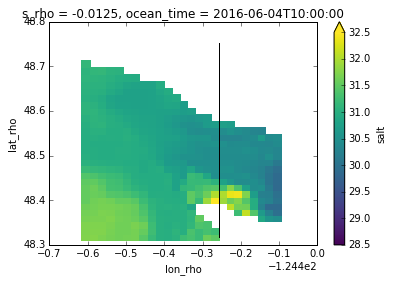

In [19]:
fig,ax=plt.subplots(1,1)
surf=d.salt.isel(ocean_time=81,s_rho=s)
surf.plot(x='lon_rho', y='lat_rho',ax=ax,vmin=28.5,vmax=32.5)
ax.plot(d.lon_rho.values[:,i], d.lat_rho.values[:,i], 'k-')

This does work! Probably because the x-slice on lat_rho is now 1D and pcolormesh can deal with this. 

For plotting with z_rho, I think that ocean_time is 1D and z_rho is 2D, so pcolormesh finds different shapes for X/Y and throws an error. 

What if I try a 1D line plot with z_rho?

TypeError: There is no Line2D property "y"

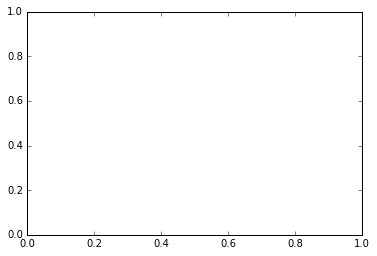

In [20]:
salt_ts.isel(ocean_time=0).plot(y='z_rho')

That won't work either.

Nonetheless, having z_rho in the xarray DataSet could still be useful, particularly for resampling. Let's see if that works.

In [21]:
daily = d.resample('1D', 'ocean_time')

In [22]:
daily.z_rho

AttributeError: 'Dataset' object has no attribute 'z_rho'

Ok, so z_rho did not get resampled and is now not part of the Dataset. What if it was a variables instead of a coordinate?

In [23]:
d = d.reset_coords('z_rho')

In [24]:
daily = d.resample('1D', 'ocean_time')
daily.z_rho

<xarray.DataArray 'z_rho' (ocean_time: 34, s_rho: 40, eta_rho: 31, xi_rho: 26)>
array([[[[ -2.02343463e+02,  -2.35217722e+02,  -2.44248967e+02, ...,
                       nan,              nan,              nan],
         [ -2.07593279e+02,  -2.23750267e+02,  -1.99839994e+02, ...,
                       nan,              nan,              nan],
         [ -2.38685642e+02,  -2.41358158e+02,  -1.97474777e+02, ...,
                       nan,              nan,  -6.73865996e+01],
         ..., 
         [             nan,              nan,              nan, ...,
                       nan,              nan,              nan],
         [             nan,              nan,              nan, ...,
                       nan,              nan,              nan],
         [             nan,              nan,              nan, ...,
                       nan,              nan,              nan]],

        [[ -1.97906569e+02,  -2.30060137e+02,  -2.38893420e+02, ...,
                       nan,   

Excellent! So basically, I shouldn't set z_rho as a coordinate because it is multi-dimensional and time dependent. I don't get the same features as other 1D coordinates. 

I think it is still worthwhile to include z_rho in the Dataset. Plotting vs z_rho will have to be done outside of xarray. And interpolating, etc too. But at least it is there.